In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

# Set the path to your zip file in Google Drive
zip_path = '/content/drive/MyDrive/DATASETSplit.zip'

# Set the extraction path
extraction_path = '/content/drive/MyDrive/AI/Shark.AI/DATASET/'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print("Zip file extracted successfully!")


Zip file extracted successfully!


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [4]:
# Original dataset directory
original_dataset_dir = '/content/drive/MyDrive/AI/Shark.AI/DATASET/DATASETSplit'

# Base directory for splits
base_dir = '/content/drive/MyDrive/AI/Shark.AI/DATASET/DATASETSplit'
os.makedirs(base_dir, exist_ok=True)

# Directories for training, validation, and testing splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subdirectories for each class in training, validation, and testing directories
classes = ['Blacktip', 'Blacktip Reef', 'Bonnethead', 'Bull', 'Great White', 'Hammerhead', 'Lemon', 'Nurse', 'Tiger', 'Whale']

for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)


In [ ]:
# Function to split dataset
def split_dataset(original_dir, train_dir, validation_dir, test_dir, split_ratio=(0.7, 0.15, 0.15)):
    for class_name in classes:
        class_dir = os.path.join(original_dir, class_name)
        images = os.listdir(class_dir)
        train_images, test_images = train_test_split(images, test_size=(1 - split_ratio[0]))
        validation_images, test_images = train_test_split(test_images, test_size=(split_ratio[2] / (split_ratio[1] + split_ratio[2])))

        for image in train_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(train_dir, class_name, image)
            shutil.copyfile(src, dst)

        for image in validation_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(validation_dir, class_name, image)
            shutil.copyfile(src, dst)

        for image in test_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(test_dir, class_name, image)
            shutil.copyfile(src, dst)

# Split the dataset
split_dataset(original_dataset_dir, train_dir, validation_dir, test_dir)


In [6]:
def count_files(directory):
    file_count = sum(len(files) for _, _, files in os.walk(directory))
    return file_count

print(f"Total training images: {count_files(train_dir)}")
print(f"Total validation images: {count_files(validation_dir)}")
print(f"Total testing images: {count_files(test_dir)}")


Total training images: 6238
Total validation images: 1338
Total testing images: 1342


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,  # This is the training directory path
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=32,
    class_mode='categorical'  # Since you have multiple classes, use categorical
)

# Flow validation images in batches of 32 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,  # This is the validation directory path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Flow test images in batches of 32 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,  # This is the test directory path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 6236 images belonging to 10 classes.
Found 1338 images belonging to 10 classes.
Found 1342 images belonging to 10 classes.


**Train Model**

In [8]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load DenseNet121 model without the top layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for your specific classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # Adjust 10 based on your number of classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


29084464/29084464 [==============================] - 1s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [9]:
import time
start_time = time.time()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# End timing the training process
end_time = time.time()
training_time = end_time - start_time
print(f'Training time: {training_time} seconds'
)

Epoch 1/50
 64/194 [========>.....................] - ETA: 1:38 - loss: 2.1634 - accuracy: 0.2750

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


194/194 [==============================] - 220s 754ms/step - loss: 1.9643 - accuracy: 0.3356 - val_loss: 2.3089 - val_accuracy: 0.3316
Epoch 2/50
194/194 [==============================] - 135s 693ms/step - loss: 1.6499 - accuracy: 0.4341 - val_loss: 1.8762 - val_accuracy: 0.4390
Epoch 3/50
194/194 [==============================] - 136s 699ms/step - loss: 1.5033 - accuracy: 0.4887 - val_loss: 1.6487 - val_accuracy: 0.4466
Epoch 4/50
194/194 [==============================] - 134s 691ms/step - loss: 1.3767 - accuracy: 0.5374 - val_loss: 2.5626 - val_accuracy: 0.4009
Epoch 5/50
194/194 [==============================] - 130s 670ms/step - loss: 1.3093 - accuracy: 0.5611 - val_loss: 1.4748 - val_accuracy: 0.4977
Epoch 6/50
194/194 [==============================] - 131s 675ms/step - loss: 1.2155 - accuracy: 0.5956 - val_loss: 1.4672 - val_accuracy: 0.5473
Epoch 7/50
194/194 [==============================] - 129s 664ms/step - loss: 1.1628 - accuracy: 0.6114 - val_loss: 2.1295 - val_accura

In [10]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reset the test generator
test_generator.reset()

# Get model predictions
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy for ResNet50: {accuracy:.4f}")

# Calculate mAP
mAP = average_precision_score(
    tf.keras.utils.to_categorical(y_true, num_classes=train_generator.num_classes),
    predictions,
    average='macro'
)
print(f"mAP for ResNet50: {mAP:.4f}")

42/42 [==============================] - 12s 243ms/step
Accuracy for ResNet50: 0.1215
mAP for ResNet50: 0.1051


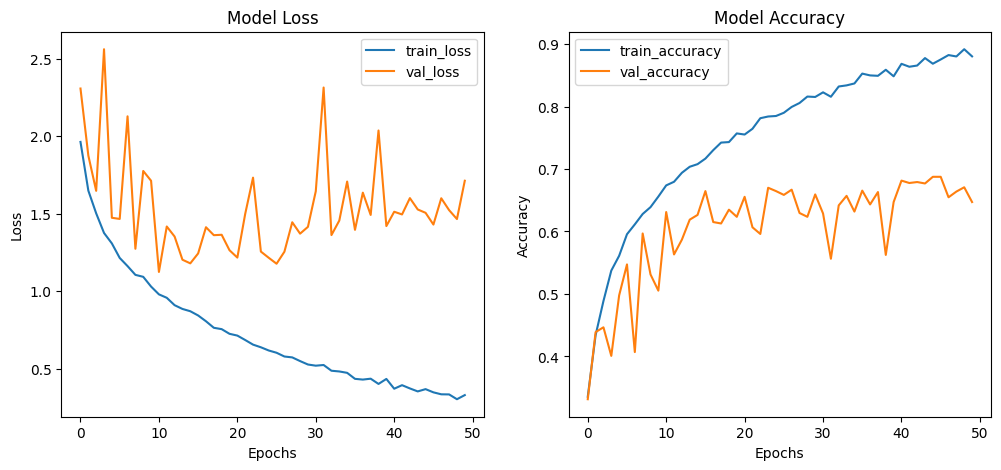

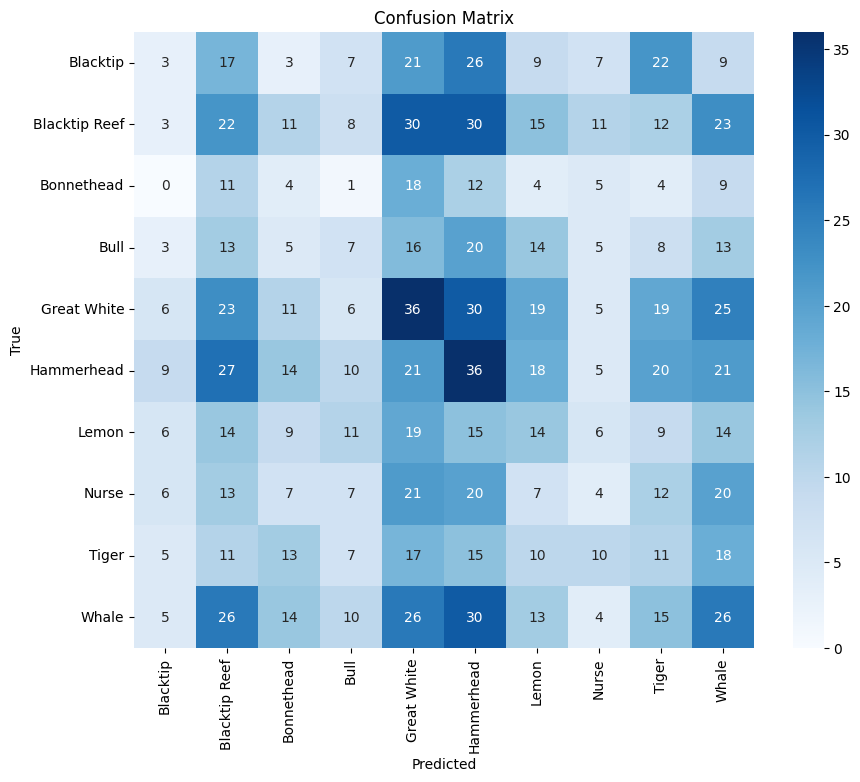

In [11]:

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Function to plot performance
def plot_performance(history, cm):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Assuming `history` is the history object returned by the `fit` method of the model
plot_performance(history, conf_matrix)